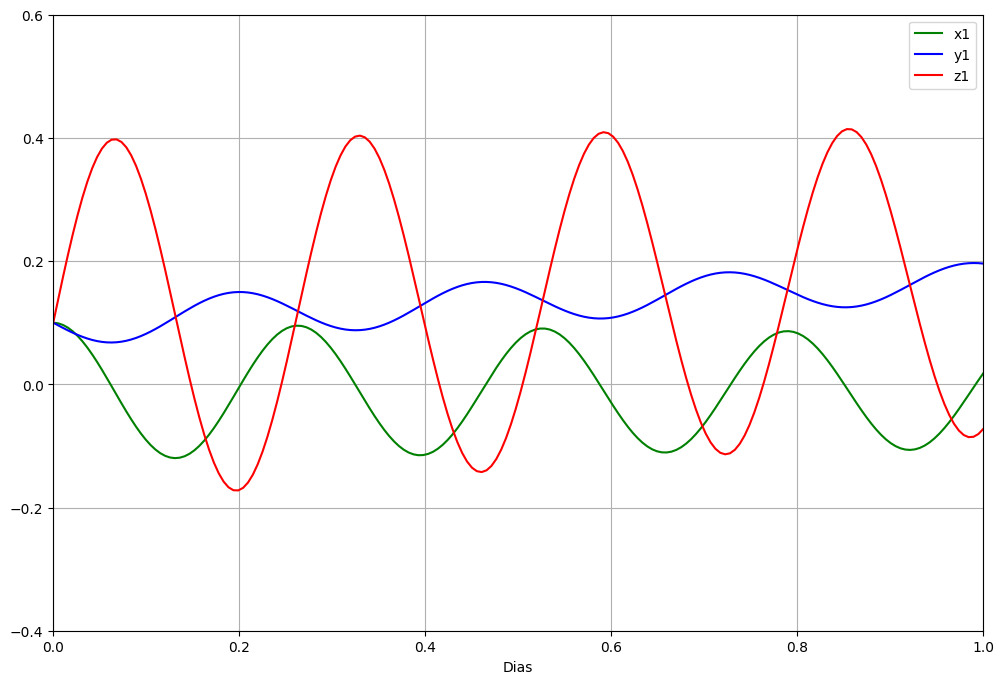

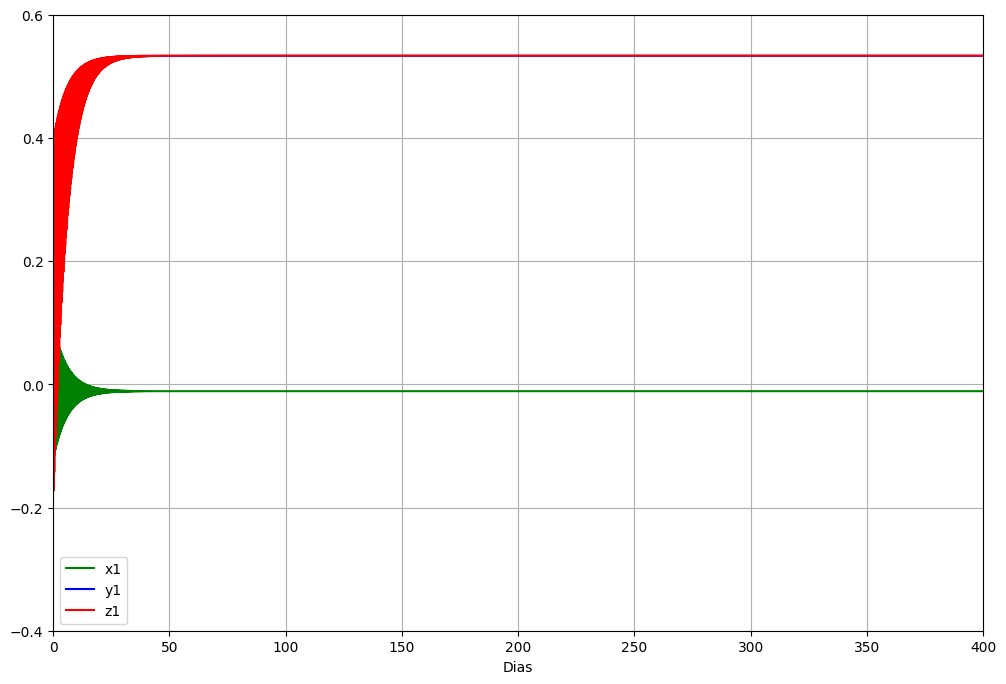

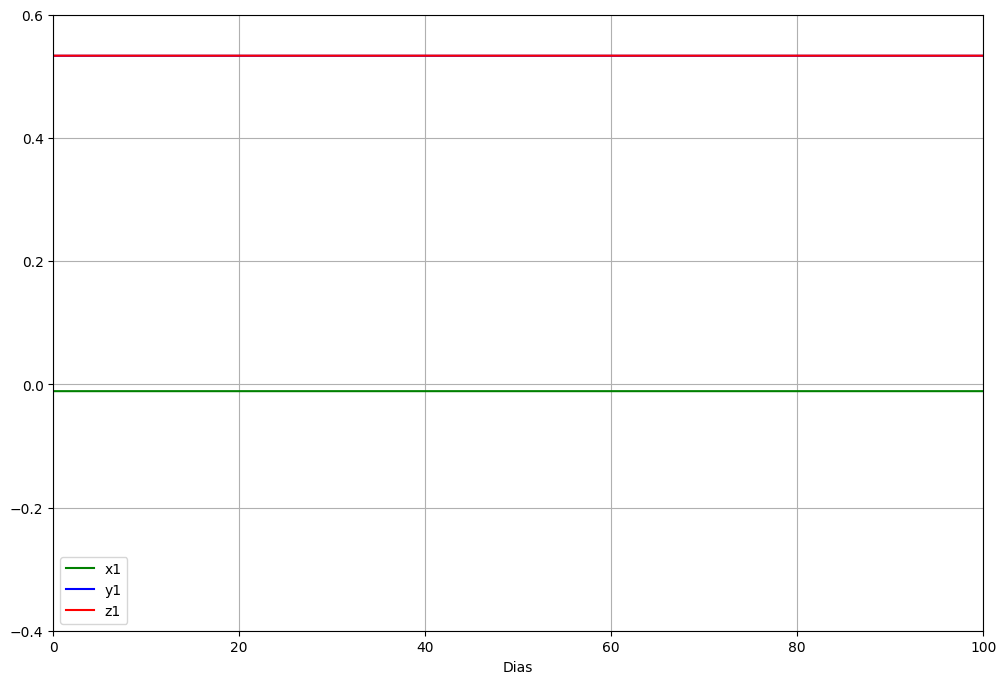

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import math

vetor_a = [1, 1, 3]
vetor_b = [
    0.5 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    0.5 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    0.5 * (vetor_a[2] - vetor_a[0] - vetor_a[1])
]
c = math.sqrt(3/4)

f_inv = 10800
vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1/48
nu_0 = kappa_0

def derivatives(x, y, z):
    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3
        
        dx[i] = (vetor_a[i]*vetor_b[i]*x[j]*x[k] - 
                c*(vetor_a[i] - vetor_a[k])*x[j]*y[k] +c*(vetor_a[i] - vetor_a[k])*x[j]*y[k] -
                c*(vetor_a[i] - vetor_a[j])*y[j]*x[k] -
                2*c**2*y[i]*y[k] -
                nu_0*vetor_a[i]**2*x[i] +
                vetor_a[i]*y[i] - 
                vetor_a[i]*z[i])
        
        dy[i] = (-vetor_a[k]*vetor_b[k]*x[j]*y[k] -
                vetor_a[j]*vetor_b[j]*y[j]*x[k] +
                c*(vetor_a[k] - vetor_a[j])*y[j]*y[k] - 
                vetor_a[i]*x[i] - 
                nu_0*vetor_a[i]**2*y[i])
        
        dz[i] = (-vetor_b[k]*x[j]*(z[k] - vetor_h[k]) -
                vetor_b[j]*(z[j] - vetor_h[j])*x[k] +
                c*y[j]*(z[k] - vetor_h[k]) -
                c*(z[j] - vetor_h[j])*y[k] +
                g_0*vetor_a[i]*x[i] -
                kappa_0*vetor_a[i]*z[i] + 
                vetor_f[i])

    return dx, dy, dz

def runge_kutta(x_inicial, y_inicial, z_inicial, dias):
    t_final = dias * 8
    dt_tau = 1/24
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = x_inicial
    y[0] = y_inicial
    z[0] = z_inicial

    for i in range(1, n_steps):
        dx1, dy1, dz1 = derivatives(x[i-1], y[i-1], z[i-1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = derivatives(x[i-1] + k1x/2, y[i-1] + k1y/2, z[i-1] + k1z/2)
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = derivatives(x[i-1] + k2x/2, y[i-1] + k2y/2, z[i-1] + k2z/2)
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = derivatives(x[i-1] + k3x, y[i-1] + k3y, z[i-1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i-1] + (k1x + 2*k2x + 2*k3x + k4x)/6
        y[i] = y[i-1] + (k1y + 2*k2y + 2*k3y + k4y)/6
        z[i] = z[i-1] + (k1z + 2*k2z + 2*k3z + k4z)/6

    t_days = t / 8
    return t_days, x, y, z

def plot2d(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(t, x[:, 0], '-', linewidth=1.5, label='x1', color='green')
    ax.plot(t, y[:, 0], '-', linewidth=1.5, label='y1', color='blue')
    ax.plot(t, z[:, 0], '-', linewidth=1.5, label='z1', color='red')

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel('Dias')
    ax.grid(True)
    ax.legend()
    
    return fig, ax

def main():
    # Condições iniciais - dia 01
    x0 = [0.1, 0, 0]
    y0 = [0.1, 0, 0]
    z0 = [0.1, 0, 0]

    # Condições fig 1 - 01 dia
    t_fig1, x_fig1, y_fig1, z_fig1 = runge_kutta(x0, y0, z0, 1)
    plot2d(t_fig1, x_fig1, y_fig1, z_fig1, 1)

    # Condições fig 1 - 400 dias
    t_fig1, x_fig1, y_fig1, z_fig1 = runge_kutta(x0, y0, z0, 400)
    plot2d(t_fig1, x_fig1, y_fig1, z_fig1, 400)

    # Condição Hardley - 100 dias
    x1 = [-0.01111, 0, 0]
    y1 = [0.53331, 0, 0]
    z1 = [0.53354, 0, 0]

    t_hardley, x_hardley, y_hardley, z_hardley = runge_kutta(x1, y1, z1, 100)
    plot2d(t_hardley, x_hardley, y_hardley, z_hardley, 100)

if __name__ == '__main__':
    main()

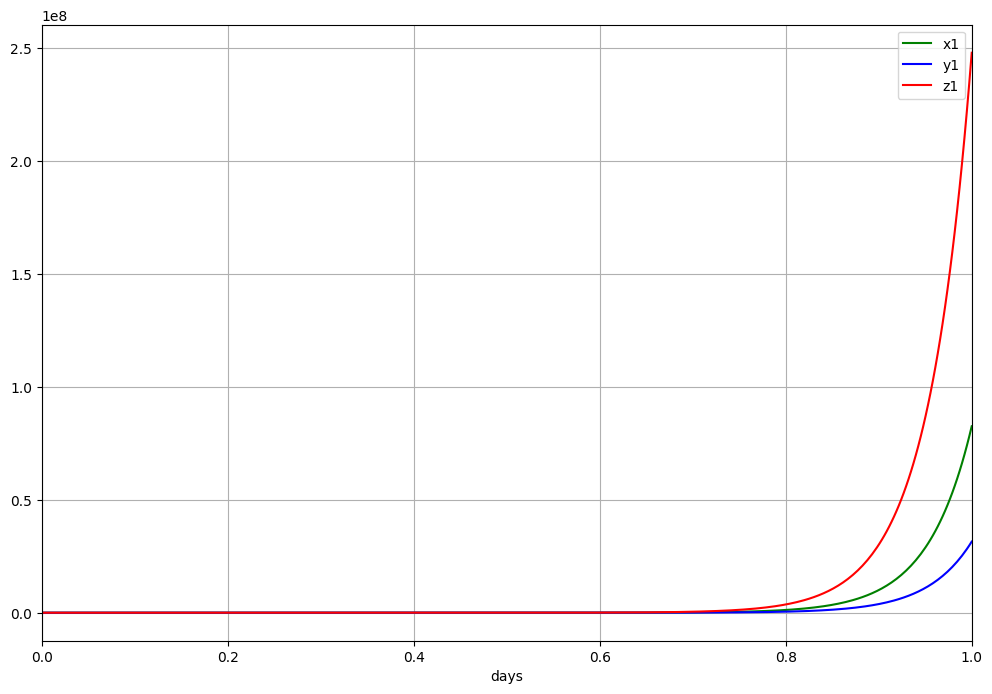

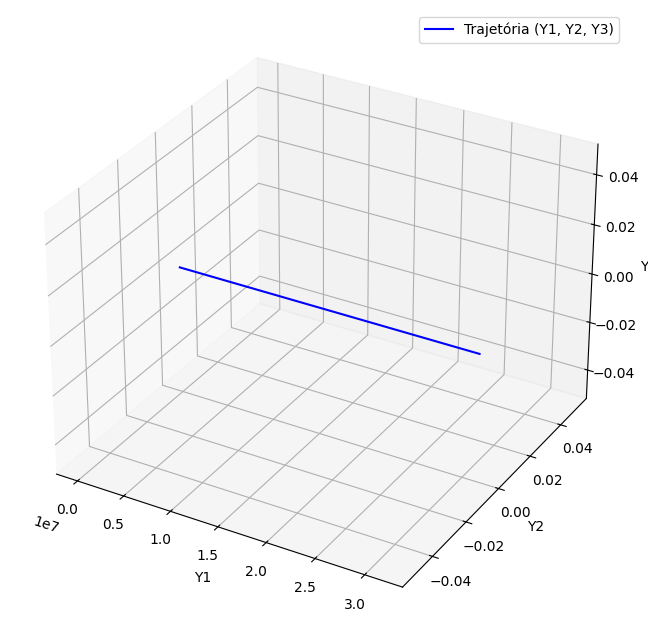

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

vetor_a = [1, 1, 3]
vetor_b = [
    0.5 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    0.5 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    0.5 * (vetor_a[2] - vetor_a[0] - vetor_a[1])
]
c = math.sqrt(3/4)

vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1/48
nu_0 = kappa_0

def derivatives(x, y, z):
    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    u = [
        -vetor_b[1] * x[0] + c * y[0],
        -vetor_b[2] * x[1] + c * y[1],
        -vetor_b[0] * x[2] + c * y[2]
    ]
    
    v = [
        -vetor_b[2] * x[0] - c * y[0],
        -vetor_b[0] * x[1] - c * y[1],
        -vetor_b[1] * x[2] - c * y[2]
    ]

    aux_x = [-vetor_a[0] * x[0], -vetor_a[1] * x[1], -vetor_a[2] * x[2]]
    aux_y = [-vetor_a[0] * y[0], -vetor_a[1] * y[1], -vetor_a[2] * y[2]]

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3


        dx[i] = u[j] * u[k] + v[j] * v[k] - nu_0 * vetor_a[i] * aux_x[i] + aux_y[i] + vetor_a[i] * z[i]
        dy[i] = u[j] * aux_y[k] + aux_y[j] * v[k] - aux_x[i] - nu_0 * vetor_a[i] * aux_y[i]
        dz[i] = u[j] * (z[k] - vetor_h[k]) + (z[j] - vetor_h[j]) * v[k] - g_0 * aux_x[i] - kappa_0 * vetor_a[i] * z[i] + vetor_f[i]

    return dx, dy, dz

def runge_kutta(dias):
    t_final = dias * 8
    dt_tau = 1/48
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = [0.1, 0, 0]
    y[0] = [0.1, 0, 0]
    z[0] = [0.1, 0, 0]

    for i in range(1, n_steps):
        dx1, dy1, dz1 = derivatives(x[i-1], y[i-1], z[i-1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = derivatives(x[i-1] + k1x/2, y[i-1] + k1y/2, z[i-1] + k1z/2)
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = derivatives(x[i-1] + k2x/2, y[i-1] + k2y/2, z[i-1] + k2z/2)
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = derivatives(x[i-1] + k3x, y[i-1] + k3y, z[i-1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i-1] + (k1x + 2*k2x + 2*k3x + k4x)/6
        y[i] = y[i-1] + (k1y + 2*k2y + 2*k3y + k4y)/6
        z[i] = z[i-1] + (k1z + 2*k2z + 2*k3z + k4z)/6

    t_days = t / 8
    return t_days, x, y, z

def plot2d(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, x[:, 0], '-', linewidth=1.5, label='x1', color='green')
    ax.plot(t, y[:, 0], '-', linewidth=1.5, label='y1', color='blue')
    ax.plot(t, z[:, 0], '-', linewidth=1.5, label='z1', color='red')

    ax.set_xlim(0, dias)
    ax.set_xlabel('days')
    ax.grid(True)
    ax.legend()

    return fig, ax

def plot3d(y, z):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(y[:, 0], y[:, 1], y[:, 2], label='Trajetória (Y1, Y2, Y3)', color='blue')
    ax.set_xlabel('Y1')
    ax.set_ylabel('Y2')
    ax.set_zlabel('Y3')
    ax.legend()
    plt.show()

def main():
    dias_simulacao = 1

    t, x, y, z = runge_kutta(dias_simulacao)
    plot2d(t, x, y, z, dias_simulacao)
    plot3d(y, z)

    plt.show()

if __name__ == '__main__':
    main()

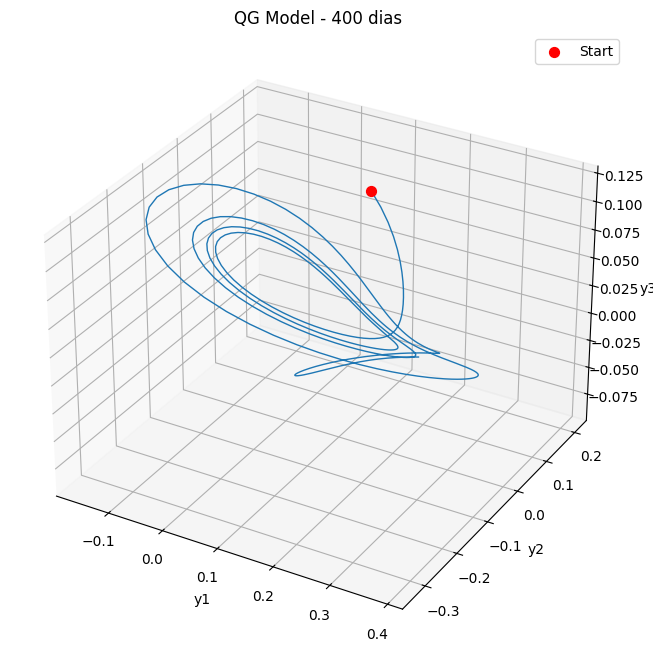

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import math

vetor_a = [1, 1, 3]
c = math.sqrt(3/4)
g_0 = 8
vetor_h = [-1, 0, 0]
kappa_0 = 1/48
nu_0 = kappa_0
vetor_f = [0.1, 0, 0]

def qg_model(y):
   dy = np.zeros(3)
   for i in range(3):
       j = (i + 1) % 3
       k = (i + 2) % 3
       dy[i] = (g_0*c*(vetor_a[k] - vetor_a[j])*y[j]*y[k]
               - vetor_a[i]*(vetor_a[i]*g_0*nu_0 + kappa_0)*y[i]
               - c*vetor_h[k]*y[j] + c*vetor_h[j]*y[k] + vetor_f[i]) / (vetor_a[i]*g_0 + 1)
   return dy

def rk4(f, y0, t):
   n = len(t)
   y = np.zeros((n, len(y0)))
   y[0] = y0
   dt = 1

   for i in range(n-1):
       k1 = f(y[i])
       k2 = f(y[i] + k1 * dt/2)
       k3 = f(y[i] + k2 * dt/2)
       k4 = f(y[i] + k3 * dt)
       y[i+1] = y[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

   return y

def plot3d(dias, y0):
   t = np.arange(0, dias)
   sol = rk4(qg_model, y0, t)

   fig = plt.figure(figsize=(10, 8))
   ax = fig.add_subplot(111, projection='3d')

   ax.plot(sol[:,0], sol[:,1], sol[:,2], lw=1)
   ax.scatter(sol[0,0], sol[0,1], sol[0,2], c='r', s=50, label='Start')

   ax.set_xlabel('y1')
   ax.set_ylabel('y2')
   ax.set_zlabel('y3')
   ax.set_title(f'QG Model - {dias} dias')
   ax.legend()

   plt.show()

def main():
   dias = 400
   y0 = [0.1, 0.1, 0.1]
   plot3d(dias, y0)

if __name__ == "__main__":
   main()